The purpose of this notebook is to predict the score of MLB games using regression algorithms. The data used in the model is historical scoring and statistics for major league baseball games throughout history. The Elo data fields are a metric used to measure the relative rating for a zero-sum outcome. The predictive model will look at a row's data without the score, and attempt to predict the score for each team.

In [49]:
import numpy as np
import pandas as pd

original = pd.read_csv("../data/mlb_elo.csv")
print(original.head(5))

      date  season  neutral playoff team1 team2     elo1_pre     elo2_pre  \
0  3/20/19    2019        1     NaN   OAK   SEA  1540.662576  1508.406103   
1  3/21/19    2019        1     NaN   OAK   SEA  1538.451430  1510.617249   
2  3/28/19    2019        0     NaN   SEA   BOS  1512.271027  1573.043870   
3  3/28/19    2019        0     NaN   KCR   CHW  1468.656479  1463.300808   
4  3/28/19    2019        0     NaN   SDP   SFG  1470.984750  1475.955269   

   elo_prob1  elo_prob2  ...  pitcher1_rgs  pitcher2_rgs  pitcher1_adj  \
0   0.546288   0.453712  ...     50.867044     50.290116     15.661717   
1   0.539971   0.460029  ...     45.343580     47.400000     -9.598335   
2   0.447276   0.552724  ...     49.933119     63.397135      8.367407   
3   0.542146   0.457854  ...     52.699258     50.660505     19.069202   
4   0.527358   0.472642  ...     46.892534     53.869991     -3.256612   

   pitcher2_adj rating_prob1 rating_prob2  rating1_post  rating2_post  score1  \
0     10.19

It should be noted that we will look at the data from 1920 - present. In the earlier years of data, some data points were missing or appeared inconsistently. Having 99 years of data will be more than sufficient to train this model.

In [50]:
trimmedDf = original[original.season >= 1920]
trimmedDf.head(5)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,3/20/19,2019,1,NaN,OAK,SEA,1540.662576,1508.406103,0.546288,0.453712,...,50.867044,50.290116,15.661717,10.194364,0.549029,0.450971,1519.121831,1492.270839,7,9
1,3/21/19,2019,1,NaN,OAK,SEA,1538.451430,1510.617249,0.539971,0.460029,...,45.343580,47.400000,-9.598335,-3.155546,0.529336,0.470664,1517.909603,1493.483066,4,5
2,3/28/19,2019,0,NaN,SEA,BOS,1512.271027,1573.043870,0.447276,0.552724,...,49.933119,63.397135,8.367407,42.091505,0.390241,0.609759,1497.190808,1557.911878,12,4
3,3/28/19,2019,0,NaN,KCR,CHW,1468.656479,1463.300808,0.542146,0.457854,...,52.699258,50.660505,19.069202,11.169670,0.540899,0.459101,1452.240404,1455.624562,5,3
4,3/28/19,2019,0,NaN,SDP,SFG,1470.984750,1475.955269,0.527358,0.472642,...,46.892534,53.869991,-3.256612,19.563483,0.531354,0.468646,1485.613206,1464.712586,2,0


Before building a model, we will do some exploratory analysis of the data. To do this, we will take a random sample of data and plot several features vs score1 and score2.

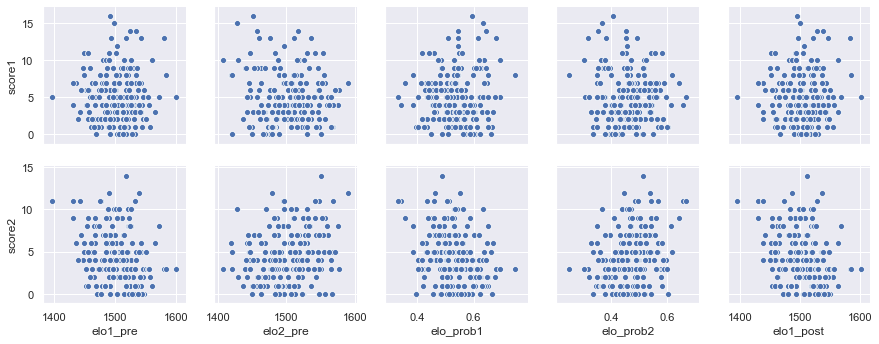

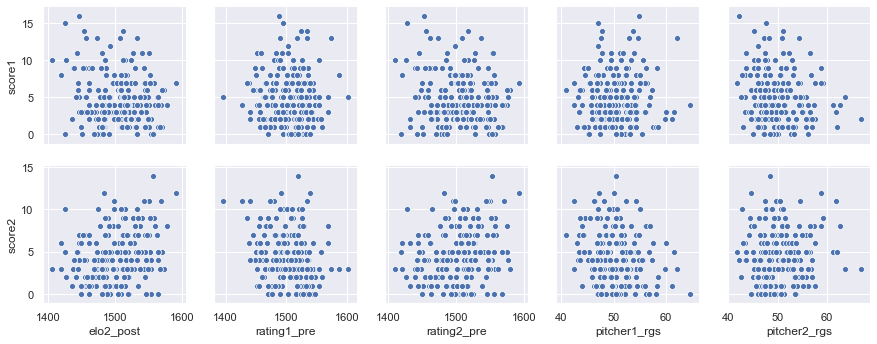

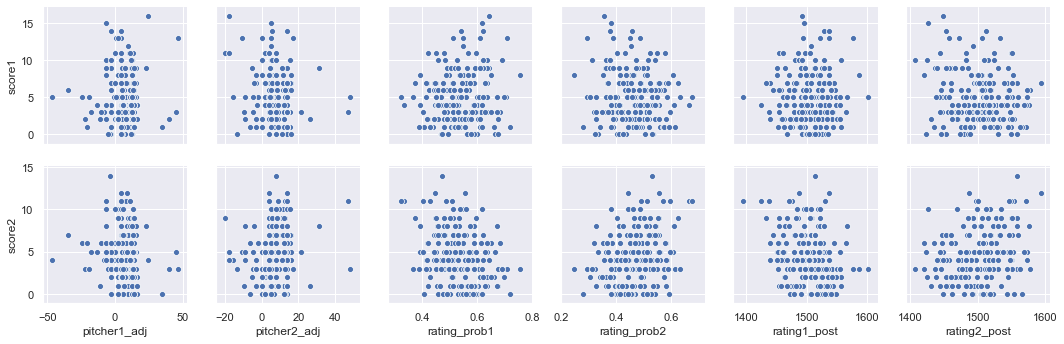

In [51]:
randomDf = trimmedDf.sample(200, random_state=1)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)

#print this in 3 different sets for readability
sns.pairplot(randomDf, x_vars=['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post'], y_vars=['score1','score2'])
sns.pairplot(randomDf, x_vars=['elo2_post', 'rating1_pre', 'rating2_pre', 'pitcher1_rgs', 'pitcher2_rgs'], y_vars=['score1','score2'])
sns.pairplot(randomDf, x_vars=['pitcher1_adj', 'pitcher2_adj', 'rating_prob1', 'rating_prob2', 'rating1_post', 'rating2_post'], y_vars=['score1','score2'])



After analyzing these charts,  it appears that there is a loose correlation between some datafields, such as a positive correlation between score2 and rating2_pre, but many appear to not be useful, such as score1 vs pitcher2_adj, where the random sample appears to be completely uncorrelated. However, since many the relationships may be subtle and difficult to pick up, we will feed all of the columns into the first model.

Next we will engage in feature engineering, specifically the subset of feature engineering by selection. There are a couple columns which will add minimal value to the model, so we will remove them. First is the playoff column. This is NaN for nearly every, if not every, row. Next is the pitcher 1 and pitcher 2 columns. A good pitcher pitches, on average, once per week. That means pitchers pitch roughly 25-30 games per season. This sample size is far too low to contribute much to the model, so we remove this data point. We will also drop the neutral column, due to its low variance in data points (and it's a binary off/on), and the date column for because the date of a game should bear no relevance on the outcome. Finally, we will delete the team-name because, while some teams are consistently strong performers (i.e. the Yankees), implying they score higher on average, it is likely to be reflected in the othere columns. A better performing team will be rated higher than a lower performing team, on average. One-hot-encoding team names would also more than triple the quantity of features we have, so I believe it is unnecessary to do this.

In [52]:
cleanedDf = trimmedDf.drop(columns=['playoff', 'neutral', 'date', 'team1', 'team2', 'pitcher1', 'pitcher2'])
cleanedDf.head(5)

,season,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2019,1540.662576,1508.406103,0.546288,0.453712,1538.451430,1510.617249,1520.811136,1490.581534,50.867044,50.290116,15.661717,10.194364,0.549029,0.450971,1519.121831,1492.270839,7,9
1,2019,1538.451430,1510.617249,0.539971,0.460029,1536.797652,1512.271027,1519.121831,1492.270839,45.343580,47.400000,-9.598335,-3.155546,0.529336,0.470664,1517.909603,1493.483066,4,5
2,2019,1512.271027,1573.043870,0.447276,0.552724,1516.745220,1568.569677,1493.483066,1561.619620,49.933119,63.397135,8.367407,42.091505,0.390241,0.609759,1497.190808,1557.911878,12,4
3,2019,1468.656479,1463.300808,0.542146,0.457854,1470.212822,1461.744466,1451.069001,1456.795966,52.699258,50.660505,19.069202,11.169670,0.540899,0.459101,1452.240404,1455.624562,5,3
4,2019,1470.984750,1475.955269,0.527358,0.472642,1472.773763,1474.166256,1484.285919,1466.039874,46.892534,53.869991,-3.256612,19.563483,0.531354,0.468646,1485.613206,1464.712586,2,0


At this point, there are NaN values in the data which are not valid in the model. We see below that there are only a few rows that include NaN. Since the max number of rows we would need to remove is 17, we can do that without any negative consequences since there are hundreds of thousands of data rows in the dataset.

In [53]:
print(cleanedDf.isnull().sum())
cleanedDf = cleanedDf.dropna()
print("After dropping NaN:")
print(cleanedDf.isnull().sum())

season          0
elo1_pre        0
elo2_pre        0
elo_prob1       0
elo_prob2       0
elo1_post       0
elo2_post       0
rating1_pre     0
rating2_pre     0
pitcher1_rgs    3
pitcher2_rgs    3
pitcher1_adj    6
pitcher2_adj    5
rating_prob1    0
rating_prob2    0
rating1_post    0
rating2_post    0
score1          0
score2          0
dtype: int64
After dropping NaN:
season          0
elo1_pre        0
elo2_pre        0
elo_prob1       0
elo_prob2       0
elo1_post       0
elo2_post       0
rating1_pre     0
rating2_pre     0
pitcher1_rgs    0
pitcher2_rgs    0
pitcher1_adj    0
pitcher2_adj    0
rating_prob1    0
rating_prob2    0
rating1_post    0
rating2_post    0
score1          0
score2          0
dtype: int64


Finally we will construct a regression model using the features above. The first step is to separate the data into X and Y data. Observe the rows are shuffled.

In [54]:
from sklearn.model_selection import train_test_split

Y = cleanedDf[['score1', 'score2']]
X = cleanedDf.drop(columns=['score1', 'score2'])

#80/20 split for train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size = .2)

print("X_test: ")
print(X_test.head())

print("Y_test: ")
print(Y_test.head())

X_test: 
        season     elo1_pre    elo2_pre  elo_prob1  elo_prob2    elo1_post  \
160827    1933  1469.495000  1517.23000   0.465896   0.534104  1465.986000   
674       2019  1550.622551  1545.72004   0.541498   0.458502  1549.115704   
96967     1977  1431.036000  1479.39900   0.464996   0.535004  1427.481000   
46987     2000  1471.367000  1492.48100   0.504153   0.495847  1474.893000   
88497     1981  1506.960000  1439.17500   0.629100   0.370900  1504.435000   

          elo2_post  rating1_pre  rating2_pre  pitcher1_rgs  pitcher2_rgs  \
160827  1520.739000  1466.339000  1517.332000     48.611000     51.744000   
674     1547.226887  1567.840477  1537.287546     55.317834     60.603508   
96967   1482.954000  1433.557000  1477.388000     47.181000     52.951000   
46987   1488.954000  1470.681000  1492.161000     48.285000     54.226000   
88497   1441.700000  1509.237000  1439.901000     56.816000     45.602000   

        pitcher1_adj  pitcher2_adj  rating_prob1  rating_pr

The first model we will apply is an ordinary least squares model.

In [55]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
                
print("Here are the weightings applied")
print(reg.coef_)

Here are the weightings applied
[[-8.85379893e-04 -6.48678084e+00 -5.18248214e+00 -3.90119596e+00
   3.90119596e+00  6.51631420e+00  5.16425110e+00 -2.57138229e+01
  -2.62958369e+01 -5.28718185e-02 -1.78234698e-02  2.34221393e-03
  -7.49114826e-03 -3.06418252e+00  3.06418252e+00  2.57122263e+01
   2.62891060e+01]
 [-9.93414088e-04 -2.99586771e+00 -3.93715824e+00 -6.98220746e+00
   6.98220746e+00  3.01698165e+00  3.92710107e+00 -2.08229219e+01
  -2.07736570e+01 -3.40140292e-02 -3.27420692e-02 -1.61029346e-03
  -2.80514657e-03 -1.29567199e+00  1.29567199e+00  2.08181831e+01
   2.07698952e+01]]


In [56]:
from sklearn.metrics import accuracy_score

#coefficient of determination R^2 of the prediction.
regPred = reg.predict(X_test)
r2_score(Y_test, regPred) 

0.4223205516335502

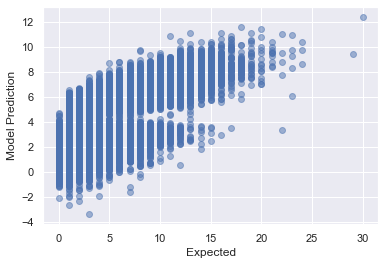

In [57]:
import numpy as np
import matplotlib.pyplot as plt

x = Y_test
y = regPred

plt.scatter(x, y, alpha=0.5)
plt.xlabel("Expected")
plt.ylabel("Model Prediction")
plt.show()

This simple regression model produces a coefficient of determination R^2 of .42, implying that the model predicts with roughly 42% accuracy. This is relatively low, however, this is a very simple model. You can see from the scatter plot that some predictions were negative, when in reality the score cannot be negative.  Next we will train a random forest model.

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=40, random_state=0,
                             n_estimators=100)
regr.fit(X_train, Y_train)  
print(regr.feature_importances_)

[0.04181217 0.14825337 0.11659523 0.01130203 0.01135477 0.18107562
 0.13822622 0.03096394 0.04670973 0.04466381 0.04385214 0.03200047
 0.0307295  0.01853032 0.01845646 0.03392105 0.05155317]


In [59]:
from sklearn.metrics import r2_score

regrPred = regr.predict(X_test)
r2_score(Y_test, regrPred) 

0.5110356206631459

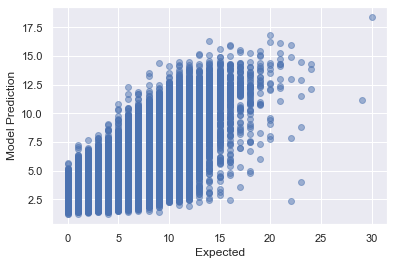

In [60]:
import numpy as np
import matplotlib.pyplot as plt

x = Y_test
y = regrPred

plt.scatter(x, y, alpha=0.5)
plt.xlabel("Expected")
plt.ylabel("Model Prediction")
plt.show()

This random forest model produces accuracy of roughly 51%. This is better than the initial model above, but still not great for how much more complex it is than the other. More likely, the model would have better luck predicting which team would win the game, rather than the exact score. However, this would be a classification algorithm (buckets would be win/loss/tie). The scatter plot shows that this model is more accurate, with no negative numbers predicted. Additionally, there is a stronger linear correlation between expected and model prediction values. The perfect model would produce a single line that contains all points. However, this is a decent model for its low difficulty in implementation.